In [138]:
# import packages
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import os
import scipy
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [20]:
# change viewing options
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', -1)

### Step 1: Import data

In [21]:
# read in the data
train = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test = pd.read_csv("test_set_features.csv")

### Step 2: Do data preprocessing, scaling, etc.

From the data exploration phase, we decided which columns were relevant to our analysis. 

So, we'll subset the training and test sets by these features

In [22]:
# get columns to subset
columns_subset = ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty']

In [23]:
# subset datasets
train_subset = train.loc[:, columns_subset]
test_subset = test.loc[:, columns_subset]

From the data imputation phase, we decided on a method to impute NaNs in our dataset

In [24]:
# split numeric and non-numeric columns
train_subset_numeric = train_subset.loc[:, ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc']]

train_subset_str = train_subset.loc[:, [ 'age_group', 'education', 'income_poverty']]

test_subset_numeric = test_subset.loc[:, ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 
                 'chronic_med_condition', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 
                 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 
                 'opinion_seas_sick_from_vacc']]

test_subset_str = test_subset.loc[:, [ 'age_group', 'education', 'income_poverty']]


Imputing numeric columns (using median)

In [25]:
# create imputer objects
imp_train = SimpleImputer(missing_values=np.nan, strategy='median')
imp_test = SimpleImputer(missing_values=np.nan, strategy='median')

# fit imputer objects
train_subset_numeric_imputed = pd.DataFrame(imp_train.fit_transform(train_subset_numeric),
                                            columns = train_subset_numeric.columns)
test_subset_numeric_imputed = pd.DataFrame(imp_test.fit_transform(test_subset_numeric), 
                                           columns = test_subset_numeric.columns)

Imputing string/categorical columns (using 'unknown' as a fill value)

In [26]:
# create imputer objects
imp_train = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'unknown')
imp_test = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'unknown')

# fit imputer objects
train_subset_str_imputed = pd.DataFrame(imp_train.fit_transform(train_subset_str),
                                            columns = train_subset_str.columns)
train_subset_str_imputed = pd.DataFrame(imp_test.fit_transform(train_subset_str), 
                                           columns = train_subset_str.columns)

Re-joining imputed data

In [27]:
# re-join data
imputed_train = pd.concat([train_subset_numeric_imputed, train_subset_str_imputed], axis = 1)
imputed_test = pd.concat([test_subset_numeric_imputed, train_subset_str_imputed], axis = 1)

### Step 3: Start fitting models

Now we can start fitting models to create our predictions. 

I will try using the following models:
1. Logistic Regression
2. Random Forest
3. Feedforward Neural Network

Before doing so, we have to one-hot-encode the categorical features. The models can only work with numeric data, so we need to transform the string data (e.g., "education", which has values like "college") so that it is numeric. 

We can use label encoding, which replaces each value in a column with a number from 0 to n-1 (with n being the # of unique values). This makes sense for our context since there is a clear ordering in the values of a column (for example, '18-34 years' is clearly less than '35-44 years')

In [34]:
imputed_train['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [30]:
print(imputed_train.dtypes)

h1n1_concern                   float64
h1n1_knowledge                 float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                      object 
education                      object 
income_poverty                 object 
dtype: object


So, we need to label encode the 'age_group', 'education', and 'income_poverty' columns

First, let's convert them to categories

In [ ]:
# first, let's change the objects to categories
imputed_train['age_group'] = imputed_train['age_group'].astype('category')
imputed_train['education'] = imputed_train['education'].astype('category')
imputed_train['income_poverty'] = imputed_train['income_poverty'].astype('category')

##### First, let's look at the 'age_group' column:

This is exactly what we expect, so we can directly use the numeric equivalents of the categories

In [ ]:
# replace categories with categorical codes
imputed_train['age_group'] = imputed_train['age_group'].cat.codes

##### Now, let's look at the 'education' column: 

In [42]:
# let's see what the categories look like
imputed_train['education'].cat.categories

Index(['12 Years', '< 12 Years', 'College Graduate', 'Some College',
       'unknown'],
      dtype='object')

These categories aren't in the right order, so we need to rearrange them. 

In [ ]:
imputed_train['education'].cat.reorder_categories(['unknown','< 12 Years', '12 Years', 'Some College', 'College Graduate'],
                                                  ordered = True, 
                                                  inplace = True)

Now, let's look at the categories

In [50]:
imputed_train['education'].value_counts() 

College Graduate    10097
Some College        7043 
12 Years            5797 
< 12 Years          2363 
unknown             1407 
Name: education, dtype: int64

We see that they are now in the correct order. Now we can replace the categories with their categorical codes

In [51]:
# replace categories with categorical codes
imputed_train['education'] = imputed_train['education'].cat.codes

##### Finally, let's look at the income_poverty column

In [53]:
# let's see what the categories look like
imputed_train['income_poverty'].cat.categories

Index(['<= $75,000, Above Poverty', '> $75,000', 'Below Poverty', 'unknown'], dtype='object')

These are in the wrong order, so we need to rearrange them

In [54]:
imputed_train['income_poverty'].cat.reorder_categories(['unknown','Below Poverty', '<= $75,000, Above Poverty', '> $75,000'],
                                                       ordered = True, 
                                                       inplace = True)


In [55]:
imputed_train['income_poverty'].cat.categories

Index(['unknown', 'Below Poverty', '<= $75,000, Above Poverty', '> $75,000'], dtype='object')

These are now in the correct order, so we can replace the categories with their categorical codes.

In [56]:
# replace categories with categorical codes
imputed_train['income_poverty'] = imputed_train['income_poverty'].cat.codes


In [57]:
imputed_train.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                      int8   
education                      int8   
income_poverty                 int8   
dtype: object

Now, all the columns are numeric in some form. For consistency, let's convert age_group, education, and income_poverty to float64 as well

In [58]:
# changing to float64
imputed_train['age_group'] = imputed_train['age_group'].astype('float64')
imputed_train['education'] = imputed_train['education'].astype('float64')
imputed_train['income_poverty'] = imputed_train['income_poverty'].astype('float64')


#### Let's perform the same data cleaning on the test set

In [97]:
# first, let's change the objects to categories
imputed_test['age_group'] = imputed_test['age_group'].astype('category')
imputed_test['education'] = imputed_test['education'].astype('category')
imputed_test['income_poverty'] = imputed_test['income_poverty'].astype('category')


In [98]:
# replace categories with categorical codes
imputed_test['age_group'] = imputed_test['age_group'].cat.codes

In [99]:
# reorder education categories
imputed_test['education'].cat.reorder_categories(['unknown','< 12 Years', '12 Years', 'Some College', 'College Graduate'],
                                                  ordered = True, 
                                                  inplace = True)

In [100]:
# replace categories with categorical codes
imputed_test['education'] = imputed_test['education'].cat.codes

In [101]:
# reorder income poverty
imputed_test['income_poverty'].cat.reorder_categories(['unknown','Below Poverty', '<= $75,000, Above Poverty', '> $75,000'],
                                                       ordered = True, 
                                                       inplace = True)


In [103]:
# replace categories with categorical codes
imputed_test['income_poverty'] = imputed_test['income_poverty'].cat.codes


In [104]:
# changing to float64
imputed_test['age_group'] = imputed_test['age_group'].astype('float64')
imputed_test['education'] = imputed_test['education'].astype('float64')
imputed_test['income_poverty'] = imputed_test['income_poverty'].astype('float64')


Now, let's split our training set into training and validation sets:

In [68]:
X_train, X_eval, y_train, y_eval = sklearn.model_selection.train_test_split(
    imputed_train,
    train_labels[['h1n1_vaccine', 'seasonal_vaccine']],
    test_size = 0.25,
    shuffle = True,
    stratify = train_labels[['h1n1_vaccine', 'seasonal_vaccine']],
    random_state = 100
)

Now, let's also create a function to evaluate the performance of our predictions. The competition evaluates our performance using a ROC-AUC curve, so we'll create a wrapper function on top of sklearn's roc-auc-curve function (the inspiration coming from this link: https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/)

In [78]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

#### Logistic Regression

Let's first fit a logistic regression to make predictions for both vaccines

In [69]:
# create model, fit
clf_logReg_h1n1 = LogisticRegression().fit(X_train, y_train['h1n1_vaccine'])


/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [70]:
# get predictions
preds_logReg_h1n1 = clf_logReg_h1n1.predict_proba(X_eval)

Now, let's fit a logistic regression to make predictions for seasonal vaccine adoption.

In [75]:
# create model, fit
clf_logReg_seas = LogisticRegression().fit(X_train, y_train['seasonal_vaccine'])


/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [76]:
# get predictions
preds_logReg_seas = clf_logReg_seas.predict_proba(X_eval)

Now, let's evaluate their results

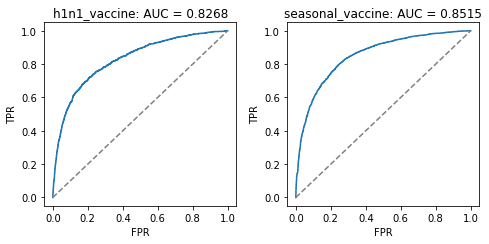

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_logReg_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_logReg_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

Now, let's get the roc-auc score directly for both categories:

In [93]:
y_preds = np.transpose(np.array([preds_logReg_h1n1[:, 1], preds_logReg_seas[:, 1]]))

In [95]:
roc_auc_score(y_eval, y_preds)


0.8391518975499702

Now, let's create a model on the full training set and then use that model to make predictions on the test set

In [105]:
# train both classifiers, fit
clf_logReg_h1n1_test = LogisticRegression().fit(imputed_train, train_labels['h1n1_vaccine'])
clf_logReg_seas_test = LogisticRegression().fit(imputed_train, train_labels['seasonal_vaccine'])

# get predictions
preds_logReg_h1n1_test = clf_logReg_h1n1_test.predict_proba(imputed_test)
preds_logReg_seas_test = clf_logReg_seas_test.predict_proba(imputed_test)



/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now, let's get the predictions

In [106]:
preds_logReg_h1n1_test.shape

(26708, 2)

In [113]:
preds_logReg_h1n1_test[:, 1]

array([0.14597483, 0.06276654, 0.34749246, ..., 0.17210534, 0.05251498,
       0.46028176])

In [126]:
# get predictions as a np array
y_preds = np.transpose(np.array([test['respondent_id'], preds_logReg_h1n1_test[:, 1], preds_logReg_seas_test[:, 1]]))


In [127]:
y_preds.shape

(26708, 3)

In [128]:
# turn into pd dataframe
y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])


In [130]:
# change respondent IDs to ints
y_preds['respondent_id'] = y_preds['respondent_id'].astype('int')

In [132]:
# set respondent IDs as index
y_preds.set_index('respondent_id')

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.145975,0.416652
26708,0.062767,0.132233
26709,0.347492,0.442359
26710,0.487337,0.884713
26711,0.175903,0.461300
...,...,...
53410,0.344159,0.409977
53411,0.074094,0.462302
53412,0.172105,0.260964


In [135]:
# export as csv
y_preds.to_csv('submissions/submission_1.csv')

Next steps: we can tinker with some of the logistic regression parameters and see if it improves performance

#### Random Forest

We can use the data from the previous section and fit a random forest classifier. 

We will need to use grid search and cross-validation to tune our random forest

First, I'll use the default parameters for random forest, fit a model based off this. Then, I'll use grid search + cv to improve our parameter.

In [140]:
# fit random forest classifier for h1n1 vaccine
clf_rf_h1n1 = RandomForestClassifier()
clf_rf_h1n1.fit(X_train, y_train['h1n1_vaccine'])
preds_rf_h1n1 = clf_rf_h1n1.predict_proba(X_eval)

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [141]:
# fit random forest classifier for seasonal vaccine
clf_rf_seas = RandomForestClassifier()
clf_rf_seas.fit(X_train, y_train['seasonal_vaccine'])
preds_rf_seas = clf_rf_seas.predict_proba(X_eval)

/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


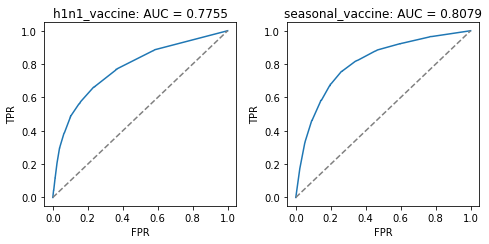

In [142]:
# evaluate results
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    preds_rf_h1n1[:, 1], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    preds_rf_seas[:, 1], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

Now, let's create this for the test set

In [143]:
# train both classifiers, fit
clf_rf_h1n1_test = RandomForestClassifier().fit(imputed_train, train_labels['h1n1_vaccine'])
clf_rf_seas_test = RandomForestClassifier().fit(imputed_train, train_labels['seasonal_vaccine'])

# get predictions
preds_rf_h1n1_test = clf_rf_h1n1_test.predict_proba(imputed_test)
preds_rf_seas_test = clf_rf_seas_test.predict_proba(imputed_test)



/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mark/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [144]:
# get predictions as a np array
y_preds = np.transpose(np.array([test['respondent_id'], preds_rf_h1n1_test[:, 1], preds_rf_seas_test[:, 1]]))


In [145]:
# turn into pd dataframe
y_preds = pd.DataFrame(y_preds, columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'])


In [146]:
# change respondent IDs to ints
y_preds['respondent_id'] = y_preds['respondent_id'].astype('int')

In [147]:
# export as csv
y_preds.to_csv('submissions/submission_2.csv')

Now, let's use grid search and cross-validation to improve our hyperparameters